In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def with_alpha(image):
    b_channel, g_channel, r_channel = cv2.split(image)

    alpha_channel = np.full(b_channel.shape, 255, dtype=b_channel.dtype)
    return cv2.merge((b_channel, g_channel, r_channel, alpha_channel))

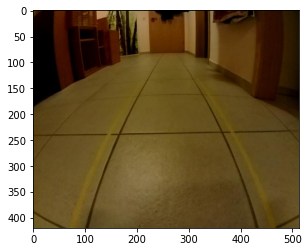

In [5]:
img = with_alpha(cv2.imread('img/WaveshareCamera.jpg')) # Read the test img
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA))
img = img[165:420, 0:513] # Apply np slicing for ROI crop

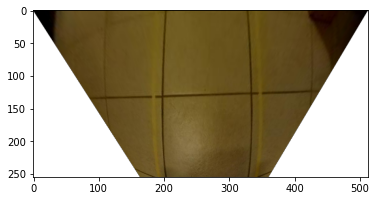

In [6]:
src = np.float32([[100, 255], [429, 255], [0, 0], [513, 0]])
dst = np.float32([[202, 255], [328, 255], [0, 0], [513, 0]])
M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix
Minv = cv2.getPerspectiveTransform(dst, src) # Inverse transformation

warped_img = cv2.warpPerspective(img, M, (513, 255)) # Image warping
plt.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGRA2RGBA))

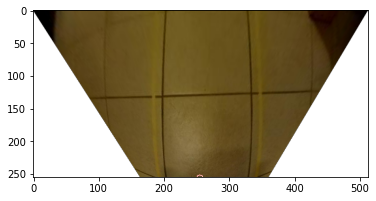

In [7]:
def rotate(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w / 2, h / 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    center = (M.dot(np.array([h, w/2, 1]).T))
    center[0] = round(max(0, min(nH, center[0])))
    center[1] = round(max(0, min(nW, center[1])))
    center = center.astype(int)

    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH)), center

angle = 0
rotated_image, center = rotate(warped_img, angle)
cv2.circle(rotated_image, tuple(center), 5, color=(0, 0, 255))

plt.imshow(cv2.cvtColor(rotated_image, cv2.COLOR_BGRA2RGBA))

In [8]:
def translate(image, x, y):
    # define the translation matrix and perform the translation
    M = np.float32([[1, 0, x], [0, 1, y]])
    shifted = cv2.warpAffine(image, M, (image.shape[1] + x, image.shape[0] + y))

    # return the translated image
    return shifted

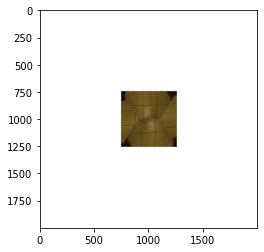

In [12]:
map = np.zeros((2000, 2000, 4), dtype=np.uint8)

def update(image, x, y, r):
    image, center = rotate(image, r)
    selfY, selfX = center
    start_x = x - selfX
    start_y = y - selfY
    map_part = map[start_x:start_x + image.shape[0], start_y: start_y + image.shape[1]]

    filled = map_part[:, :, 3] != 0
    result = np.zeros_like(map_part)
    result[:, :, 0] = filled * map_part[:, :, 0] + (1 - filled) * image[:, :, 0]
    result[:, :, 1] = filled * map_part[:, :, 1] + (1 - filled) * image[:, :, 1]
    result[:, :, 2] = filled * map_part[:, :, 2] + (1 - filled) * image[:, :, 2]
    result[:, :, 3] = filled * map_part[:, :, 3] + (1 - filled) * image[:, :, 3]

    map[start_x:start_x + image.shape[0], start_y: start_y + image.shape[1]] = result

update(warped_img, 1000, 1000, 0)
update(warped_img, 1000, 1000, 180)
update(warped_img, 1000, 1000, 90)
update(warped_img, 1000, 1000, 270)
plt.imshow(cv2.cvtColor(map, cv2.COLOR_BGRA2RGBA))


In [11]:
map = {}

def update(image, x, y, heading):
    image, center = rotate(image, heading)
    
    self_y, self_x = center
    start_x = x - self_x
    start_y = y - self_y
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            px = map.get((start_x + i, start_y + j), None)

            if px is not None:
                filled = px[3] != 0
                px[0] = filled * px[0] + (1 - filled) * image[i, j, 0]
                px[1] = filled * px[1] + (1 - filled) * image[i, j, 1]
                px[2] = filled * px[2] + (1 - filled) * image[i, j, 2]
                px[3] = filled * px[3] + (1 - filled) * image[i, j, 3]
            else:
                px = image[i, j]

            map[(start_x + i, start_y + j)] = px



update(warped_img, 1000, 1000, 0)
update(warped_img, 1000, 1000, 180)
update(warped_img, 1000, 1000, 90)
update(warped_img, 1000, 1000, 270)

